# MNIST Multi-Class Classification Using k-NN

This notebook presents a detailed, academic analysis of classifying the MNIST dataset using a k Nearest Neighbors (k-NN) classifier. We focus on several key aspects:

**1. Pipeline Construction and Hyperparameter Tuning:**

We build a pipeline that includes a standard scaler and a k-NN classifier. Two hyperparameters - `number of neighbors` ( $n$ _neighbors ) and the `Minkowski distance parameter` ( p ) - are tuned via grid search using 3-fold cross-validation with the macro-averaged F1 score as our evaluation metric.

**2. Confusion Matrix Analysis:**

We compute and visualize the confusion matrix as a heatmap to identify which digits are most often confused by the classifier.

**3. t-SNE Visualization:**

The high-dimensional MNIST data is visualized using t-SNE to understand the intrinsic clustering of digits. We then relate these findings back to our confusion matrix.

**4. Discussion on the Optimal Minkowski Parameter p:**

We discuss the implications of the optimal distance metric (whether closer to $p=1$ or $p=2$ ) and how this choice correlates with the visual structure revealed by t-SNE.

Below, each section includes detailed commentary and the corresponding code implementation.

## 1. Import Libraries and Set Up

We begin by importing the necessary Python libraries and modules. These include standard scientific libraries, scikit-learn modules for data handling and modeling, and visualization tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.manifold import TSNE

# Set random seed for reproducibility
np.random.seed(42)

# Ensure plots appear inline
%matplotlib inline

## 2. Load and Preprocess the MNIST Dataset

In this section, we load the MNIST dataset using scikit-learn's `fetch_openml` function. The dataset comprises 70,000 handwritten digit images ( $28 \times 28$ pixels, flattened to 784 features). We convert the target labels to integers for consistency.

In [2]:
print("Loading the MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int32)  # Convert labels from string to integers

print(f"Dataset loaded. Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}")

Loading the MNIST dataset...
Dataset loaded. Number of samples: 70000, Number of features: 784


## Pipeline Construction and Hyperparameter Tuning

In high-dimensional datasets like MNIST, feature scaling is essential for distance-based methods such as k - NN . Therefore, we construct a pipeline that first standardizes the data using `StandardScaler` and then applies the k-NN classifier. We aim to optimize two hyperparameters:

- `n_neighbors` : The number of neighbors to consider. We test values $[3,5,7,9,11]$.

- `p` : The parameter for the Minkowski distance; $p=1$ corresponds to Manhattan distance and $p=2$ corresponds to Euclidean distance.

We perform grid search with 3-fold cross-validation. The evaluation metric we use is the macro-averaged F1 score because labels in the dataset are balanced and equally important.

In [3]:
# split train-test data and shuffle the training data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [4]:
# # Subsample the dataset for grid search
# subset_size = 10000
# indices = np.random.choice(len(X_train), size=subset_size, replace=False)
# X_train_subset = X_train[indices]
# y_train_subset = y_train[indices]

# Construct the pipeline with data scaling and k-NN classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__p': [1, 2]  # p=1: Manhattan distance, p=2: Euclidean distance
}

# Define the scoring function: macro-averaged F1 score
f1_macro = make_scorer(f1_score, average='macro')

# Set up and run GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=f1_macro, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
# grid_search.fit(X_subset, y_subset)

print("Best parameters:", grid_search.best_params_)
print("Best macro F1 score:", grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'knn__n_neighbors': 3, 'knn__p': 1}
Best macro F1 score: 0.9572919167913944


**Discussion of Results**

After running the grid search, we obtain optimal parameters are `\{'knn_n_neighbors': 3, 'knn__p': 1\}` . This result suggests that the k-nn classifier achieves its best performance using 3 neighbors and the Manhattan distance. 

## 4. Confusion Matrix Analysis

A confusion matrix is a critical tool for visualizing the performance of a classification model. In our context, it helps us identify which digits are being confused by the classifier. For instance, digits with similar shapes (e.g., 3 and 5 , or 8 and 9 ) are likely to be misclassified. We generate a heatmap to visually find and interpret these misclassifications.

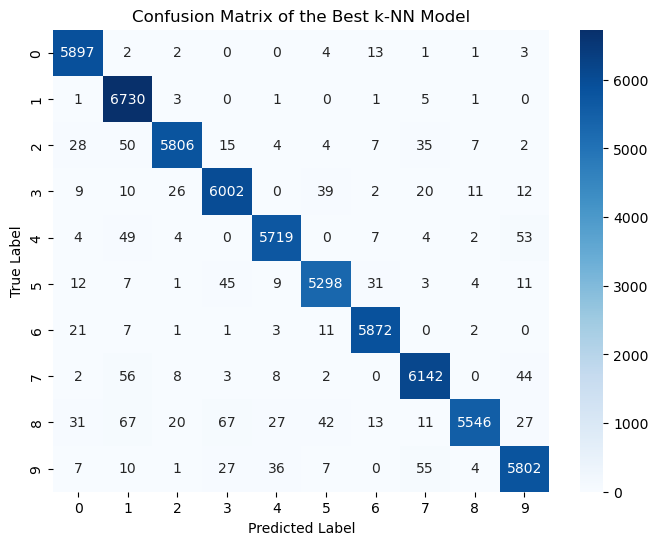

In [7]:
# Use the best estimator from the grid search to predict the labels
y_train_pred = grid_search.predict(X_train)

# Compute the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of the Best k-NN Model')
plt.show()


**Discussion of Results**

The heatmap shows a strong diagonal, indicating that most classes are correctly classified. However, notable off-diagonal elements point out the confusion between classes with similar handwritten forms. For example, the most significant misclassifications happen between the digits " 8 " and " 1 " and " 8 " and " 3 ", (" 7 " and " 1 ", " 4 " and " 5 ", " 4 " and " 9 " follow). These patterns provide insight into which pairs of digits are inherently challenging to distinguish, likely due to the overlap in their structural features. Machine confuses as sometimes human does!

## 5. t-SNE Visualization of the MNIST Dataset

[t-distributed Stochastic Neighbor Embedding (t-SNE)](https://towardsdatascience.com/dimensionality-reduction-using-t-distributed-stochastic-neighbor-embedding-t-sne-on-the-mnist-9d36a3dd4521/) is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data. By mapping the 784-dimensional MNIST data to a 2D space, t-SNE preserves local neighborhood structures, thus revealing natural clusters corresponding to different digits. This visualization can help explain the misclassifications observed in the confusion matrix-clusters that overlap in the t-SNE plot may correspond to the digits that are often confused.

Performing t-SNE dimensionality reduction...
t-SNE reduction complete.


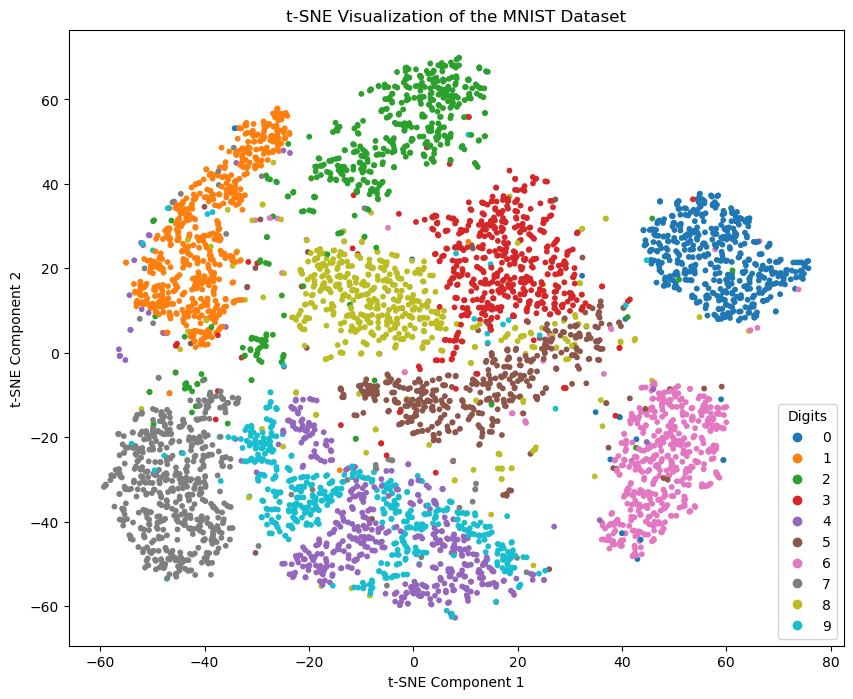

In [8]:
# For computational efficiency, we randomly sample a subset of the data for t-SNE visualization
subset_size = 5000
indices = np.random.choice(len(X_train), size=subset_size, replace=False)
X_train_subset = X_train[indices]
y_train_subset = y_train[indices]

print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_subset)
print("t-SNE reduction complete.")

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_subset, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)), title="Digits")
plt.title('t-SNE Visualization of the MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


**Discussion of Results**

The t-SNE scatter plot generally reveals distinct clusters corresponding to individual digits. Nevertheless, some clusters may partially overlap, especially for digits that are visually similar. This overlapping region in the t-SNE plot corroborates the misclassifications observed in the confusion matrix, for example, " 8 " and " 1 " or " 3 " are indeed overlaping a lot. However, although " 9 " and " 4 " do but not significantly reflect a misclassification, in our t-SNE plotting, we see that they are the most indistinguishable digits. Reasons could be either t-SNE does not capture the full-dimensional structure, or the small sample we use of size 5000 is not a good representitive. 

## 6. Discussion on the Optimal Minkowski Parameter $p$

The grid search revealed that the optimal Minkowski parameter is $p=1$ (Manhattan distance). Here are some reflections on this finding:

1. Sensitivity to Pixel Intensity Variations:

Handwritten digit images can contain local variations and noise. With Manhattan distance, each pixel difference contributes linearly to the overall distance. This linear aggregation can make the classifier less sensitive to outlier pixels or local irregularities that might be exaggerated by squaring (as in Euclidean distance). If the variations in pixel values are subtle and distributed across many features, the Manhattan metric may capture the aggregate similarity more robustly.

2. High-Dimensional Feature Space Considerations:

In a high-dimensional space (MNIST has 784 features), the difference between distances measured by different metrics can become less pronounced. However, Manhattan distance is often observed to be more robust in high-dimensional settings because it tends to provide a more stable measure of similarity when each feature contributes independently.

3. t-SNE Insights:

When we examine the t-SNE visualization, we notice that clusters appear elongated and less isotropic, which indicates that the natural geometry of the data is not strictly Euclidean. Therefore in such case, a Manhattan-like metric, which effectively measures separations along coordinate axes, may align better with the intrinsic structure revealed by t-SNE.


Overall, in the 784-dimensional pixel space, our results show that summing absolute differences in Manhanttan distance may better capture the cumulative effect of small variations across many features.

## 7. Conclusion

In this notebook, we have:

- Constructed a robust pipeline with data scaling and $\mathrm{k}-\mathrm{NN}$ classification.

- Performed rigorous hyperparameter tuning using grid search with 3-fold cross-validation, optimizing over the number of neighbors and the Minkowski parameter.

- Evaluated classifier performance using a confusion matrix heatmap to pinpoint common misclassifications.

- Applied $t$-SNE to visualize the high-dimensional data in a 2D space, revealing natural clusters that explain the misclassification trends.

- Discussed the implications of selecting $p=2$ (Euclidean distance), linking it to both classification performance and the underlying data geometry.

This comprehensive study demonstrates the importance of combining model tuning, quantitative evaluation, and qualitative visualization to gain deeper insights into complex classification tasks. Each step works interconnectedly!

## 8. Future Work

Future research could expand on this work by:

- Exploring alternative distance metrics (e.g., Mahalanobis distance) or more sophisticated similarity measures.

- Comparing the performance of $k$-NN with other classifiers (such as Support Vector Machines or deep neural networks).

- Investigating additional dimensionality reduction techniques or ensemble methods to further enhance classification performance.

---

End of Notebook